<a href="https://colab.research.google.com/github/Boris2232/Machine-Learning-Project/blob/main/Model_and_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# importing libraries
# here we will use pytorch, very fast and convenient library
import os
# library to work with math
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import shutil
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# for some researches of speed
import time
from tqdm.auto import tqdm
# library to show progress as a beautiful green bar
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now we need to clean datasets and remain only information about age.If your task is to make emotions-classifier or other, you can leave required columns.
Before:

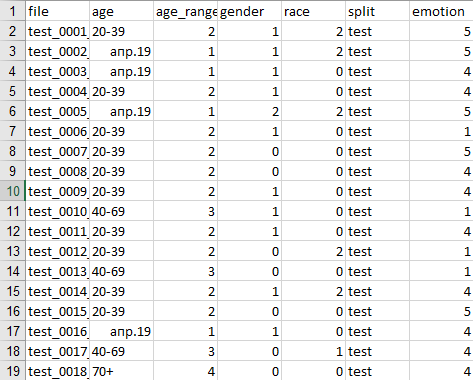


After:


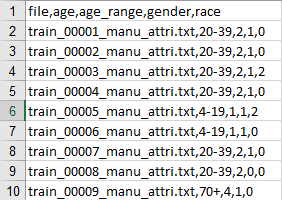


In [9]:
import csv

import pandas as pd
# manipulation with data to delete other columns which we will not use
# here we will use pandas library with its to_csv and read_csv functions
with open('RAF_DB.csv', 'r') as file:
    csv_file = pd.read_csv(file, delimiter=';')
    RAF_DB_train = csv_file.loc[csv_file['split'] == 'train']
    RAF_DB_test = csv_file.loc[csv_file['split'] == 'test']
all = RAF_DB_train.columns
headers = RAF_DB_train.columns[0:5:]
for i in all:
    if i not in headers:
        del RAF_DB_train[i]
        del RAF_DB_test[i]
# df = RAF_DB.drop('Na', axis=1)
RAF_DB_train.to_csv('RAF_DB_train.csv', header=headers,index=False)
RAF_DB_test.to_csv('RAF_DB_test.csv', header=headers,index=False)
# show one image
# img = mpimg.imread('./Aligned_images/aligned/test_0001_aligned.jpg')
# imgplot = plt.imshow(img)
# plt.show()

Here we choose resolution of our photos and resize all of them in dataset.

transforms.resize => Composes several transforms together.

transforms.ToTensor() => Convert a PIL Image or ndarray to tensor and scale the values accordingly



In [10]:
image_dataset_path='./drive/MyDrive/Aligned_images_with_utk'
# lets chose a size for our photos
dimension_for_utk=(100,100)
train_transform=transforms.Compose([transforms.Resize(dimension_for_utk),transforms.ToTensor()])
# our images now have resolution of 100x100 and the data is transformed ToTensor  transforms.RandomHorizontalFlip(),transforms.RandomRotation

A generic data loader where the images are arranged in this way by default:

                            root/dog/xxx.png

                            root/dog/xxy.png

                            root/dog/[...]/xxz.png


                            root/cat/123.png

                            root/cat/nsdf3.png

                            root/cat/[...]/asd932_.png
Here you need to choose the root folder where all images are stored. For each image we apply changes => transform=train_transform

In [11]:
# loading training dataset
train_dataset= torchvision.datasets.ImageFolder(root=f'{image_dataset_path}/Train',transform=train_transform)

With torch.utils.data.DataLoader we load image dataset, choose number of pictures in one batch and set shuffle

[shuffle (bool, optional) – set to True to have the data reshuffled at every epoch]

In [12]:
train_load=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=128,shuffle=False)

For the best perfomance of our model we need to normalize each image.

Code below counts  [MEAN and STD], which will be used for Normalization.

In [13]:
# get mean and std values to make working experience easier
def get_mean_and_std_values(file):
    mean=np.zeros(1)[0]
    std=np.zeros(1)[0]
    images_count=0
    images_count=0
#     now we need to reshape imaged
    for images,labels in file:
        counter_in_batch=images.size(0)
        images=images.view(counter_in_batch,images.size(1),-1)
        #now we got images with a shape of torch.Size([50, 3, 10000])
        #lets compute mean and std values
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        images_count+=counter_in_batch
#     images count=Number of datapoints => we considered all values
    mean,std=[i/ images_count for i in [mean,std]]
    return mean,std

mean,std=[0.5893, 0.4544, 0.3946],[0.2142, 0.1924, 0.1834] - Raf db + UTK
Here i store mean and std values, because counting it every time takes time.

We resize images to 100x100 and  Normalize them.

In [14]:
mean,std=[0.5487, 0.4178, 0.3607],[0.2098, 0.1868, 0.1776]
train_transforms=transforms.Compose([
    transforms.Resize(dimension_for_utk),transforms.ToTensor(),
    transforms.Normalize(mean,std),
#     transforms.RandomRotation(degrees=(30,70)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5)
])
test_transforms=transforms.Compose([
    transforms.Resize(dimension_for_utk),transforms.ToTensor(),
    transforms.Normalize(mean,std),
#     transforms.RandomRotation(degrees=(30,70))
])

Now let's load datasets with ImageFolder function and transform them.
See documentation:
https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html




In [30]:
train_dataset= torchvision.datasets.ImageFolder(root=f'{image_dataset_path}/Train',transform=train_transforms)
test_dataset= torchvision.datasets.ImageFolder(root=f'{image_dataset_path}/Test',transform=test_transforms)
print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 30837
    Root location: ./drive/MyDrive/Aligned_images_with_utk/Train
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5487, 0.4178, 0.3607], std=[0.2098, 0.1868, 0.1776])
           )
Dataset ImageFolder
    Number of datapoints: 3068
    Root location: ./drive/MyDrive/Aligned_images_with_utk/Test
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5487, 0.4178, 0.3607], std=[0.2098, 0.1868, 0.1776])
           )


Now we can see some random images from our dataset. Function below extract images and their labels and shows Normalized pictures.

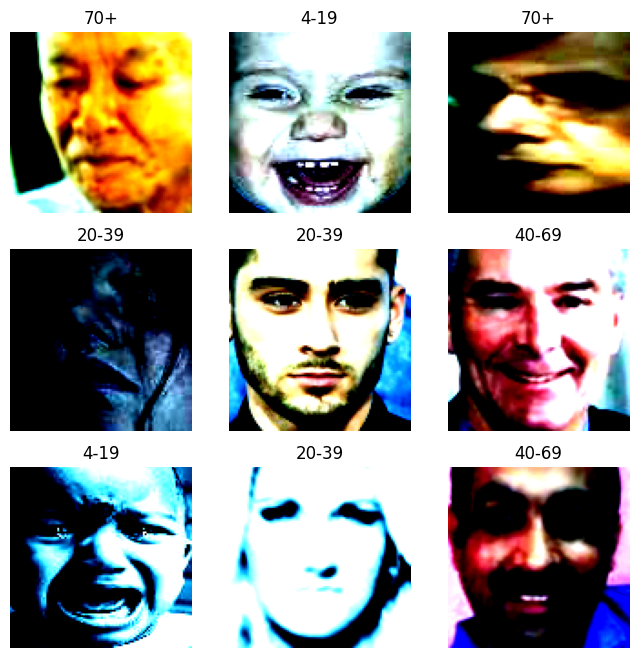

In [16]:
# now we can see that our images are significantly transformed with mean and std values, general formula is image.param-mean/std
#  new images are a bit strange but it will speed up training process
def show_transformed(dataset):
    # to show labels in convenient format
    labels_map_utk_raf={0:'0-3',1:'4-19',2:'20-39',3:'40-69',4:'70+'}
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map_utk_raf[label])
        plt.axis("off")
        plt.imshow(img.squeeze().permute(1,2,0), cmap="gray")
    plt.show()
show_transformed(train_dataset)

Convert datasets to DataLoader type

In [17]:
#  loading datasets
# shuffle - to load images to batches and shuffle them
# num_workers - helps CPU to train faster
# pin_memory - to speed up a model
BATCH_SIZE=128
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)

The most interesting part - to use cuda:0 instead of your cpu memory. It is possible only with installing special drivers from invidia. Also it is important to choose right version of cuda and connect it with pytorch.

To check if cuda can be used on your computer try to write torch.cuda.is_available()

Cuda can make training process much more faster, but it requires some additional memory.

In [18]:
# lets start our project
# we will tru to do parallel computing
def change_cpu():
    return ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
device = change_cpu()
device

'cuda:0'

Now let's write model for training. In this project i chose to work with pytorch models, in spite of being simple, this model showed good results.

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models
class Model(nn.Module):
    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 12 * 12, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [21]:
model=Model(5)
model

Model(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)

"Train" is a function which gives information to a model, there is a opportunity to train model with different hyperparameters and number of epochs. Also i added L1 and L2 regularization and penalty to a loss. After getting loss model renews its weights and returns accuracy of every epoch.

In [22]:
# train our model
def train(model,train_loader,optimizer,criterion):
    model.train()
    print('Training')
    running_loss = 0.0
    running_correct = 0
    counter = 0
#     tqdm python module to show progress bar
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            images,labels=data
#             passing images and labels to Cuda since it helps to make our training faster
            images=images.to(device)
            labels=labels.to(device)
            counter+=1
#             setting gradients to zero
            optimizer.zero_grad()
#       to print outputs
            outputs=model(images)
#        take predictions of a model from outputs
            _,predictions=torch.max(outputs.data,1)
#  with using nn.CrossEntropyLoss() compute loss with passing outputs and labels as arguments (output-predicted, label-exact value)
            loss=criterion(outputs,labels)
# Apply L2 regularization to the loss
            l2_reg = torch.tensor(0.0).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += weight_decay * l2_reg
#        after having a loss we can update W and b values with gradients using back propagation
            loss.backward()
#        updating optimizer parameters
            optimizer.step()
            running_loss+=loss.item()
#       if the prediction is true we add 1 to sum, 0 otherwise
            running_correct+=(labels==predictions).sum().item()
#       calculating loss epochs
    epoch_loss=running_loss/counter
    epoch_accuracy=100.*(running_correct/len(train_loader.dataset))
    return epoch_loss,epoch_accuracy

In [84]:
# setting learning parameters and Model initialization
weight_decay = 1e-4
# learning rate is a hyperparameter which requires experimental tuning
learning_rate=0.0005
# number of epochs
epochs=2
classes_raf = ('0-3','4-19','20-39','40-69','70+')
# to confirm that device is cuda
print(f'Computational device: {device}')
# passing model to device to speed it up
model=model.to(device)
# choosing optimizer - important step. I chose Adam
# weight_decay - L2 regularization
optimizer=optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
criterion=nn.CrossEntropyLoss()

Computational device: cuda:0


Next function draws Accuracy and Loss plots after passing all epochs.

The figure can be saved in folder

In [81]:
def draw_plots(train_accuracy, test_accuracy, train_loss, test_loss):
    #     to draw plots of accuracy and loss of train and test datasets
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='blue', linestyle='--',
             label='train accuracy')
    plt.plot(test_accuracy, color='red', linestyle='--',
             label='test accuracy')
    plt.ylabel = ('Accuracy')
    plt.xlabel = ('Epochs')
    plt.legend()
    plt.savefig('./drive/MyDrive/outputs/accuracy.jpg')
    #     loss plot
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='blue', linestyle='--',
             label='train loss')
    plt.plot(test_loss, color='red', linestyle='--',
             label='test loss')
    plt.ylabel = ('Loss')
    plt.xlabel = ('Epochs')
    plt.legend()
    plt.savefig('./drive/MyDrive/outputs/loss.jpg')
    plt.show()

In [60]:
# here we extract names from a test dataset, it will be usefull for Confusion matrix.
def get_images_name():
    dataset = test_loader.dataset
    names=list(map(lambda x:str(x).split('/')[-1],dataset.imgs))
    img_names=[]
    # ["test_0035_aligned.jpg', 0)", "test_0036_aligned.jpg', 0)", "test_0069_aligned.jpg', 0)"
    for i in names:
        img_names.append(i.split("'")[0])
    return img_names

In [75]:
# to save trained model
# you can use already pretrained weights
def save_model(epochs,model,optimizer,criterion):
    torch.save({
        'epoch':epochs,
#         saving learnable parameters (i.e. weights and biases) of the model in a dictionary
        'model_state_dict':model.state_dict(),
#         saving hyperparameters of the optimizer in a dictionary
        'optimizer_state_dict':optimizer.state_dict(),
        'loss':criterion,
    },'./drive/MyDrive/outputs/model.pth')

In [76]:
# we need to store every image name for future infographics
img_names=get_images_name()
img_names[0]
# RAF_DB_test - file	age	age_range	gender	race:    0	test_0001_manu_attri.txt	20-39	2	1	2

'test_0035_aligned.jpg'

In [77]:
# drawing Confusion matrix for statistical analysis
def final_matrix(matrix,leng):
    my_matrix=torch.zeros(leng,leng,dtype=torch.int32).tolist()
    for i in matrix:
        my_matrix[i[0]][i[1]]+=1
    my_matrix=np.array(my_matrix)
    my_matrix=(my_matrix.T/my_matrix.sum(axis=1)).T
    plt.figure(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=my_matrix, display_labels=classes_raf)
    disp.plot()
    plt.savefig('./drive/MyDrive/outputs/Confusion_matrix.jpg')
    plt.show()

In [78]:
# show and save pie plots. They show mistake distribution.
def Infographics(Prediction_list):
    df=RAF_DB_test
    counter = 1
    wrong_images = []
#     to extract in what images my model makes mistake
    for name, corr in Prediction_list:
        image_name = f'{name.split("_")[0]}_{"0" * (4 - len(str(counter)))}{counter}_manu_attri.txt'
        if corr is False and df[df['file'] == image_name]['age'].iloc[-1] == '70+':
            wrong_images.append(df['file'][df['file'] == image_name].iloc[-1])
        counter += 1
    predictions_for_gender = list(
        map(lambda x: [df['gender'].loc[df['file'] == f'{"_".join(x[0].split("_")[:2])}_manu_attri.txt'].iloc[-1], x[1]],
            Prediction_list))
    values_for_bar = [[0, 0], [0, 0], [0, 0]]
    for i in predictions_for_gender:
        if i[1] is True:
            values_for_bar[i[0]][0] += 1
        else:
            values_for_bar[i[0]][1] += 1
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    colors = ['cadetblue', 'violet', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'maroon', 'coral']
    genders=['Male', 'Female','Unsure']
    fig.tight_layout(pad=6.0)
    explode = [0, 0.1]
    for i in range(len(values_for_bar)):
        axes[i].pie(values_for_bar[i], labels=['Correct', 'Incorrect'], shadow=True, autopct='%1.1f%%', colors=colors, explode=explode,
                    startangle=90)
        axes[i].axis('equal')
        axes[i].legend(loc='upper left', title=f'{genders[i]} errors', fontsize='large')
    plt.savefig('./drive/MyDrive/outputs/Gender_errors.jpg')
#
#
#     prediction for each Race
    predictions_for_races = list(
        map(lambda x: [df['race'].loc[df['file'] == f'{"_".join(x[0].split("_")[:2])}_manu_attri.txt'].iloc[-1], x[1]],
            Prediction_list))
    values_for_bar = [[0, 0], [0, 0], [0, 0]]
    for i in predictions_for_races:
        if i[1] is True:
            values_for_bar[i[0]][0] += 1
        else:
            values_for_bar[i[0]][1] += 1
    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    colors = ['cadetblue', 'violet', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'maroon', 'coral']
    races=['Caucasian', 'African-American', 'Asian']
    fig.tight_layout(pad=6.0)
    explode = [0, 0.1]
    for i in range(len(values_for_bar)):
        axes[i].pie(values_for_bar[i], labels=['Correct', 'Incorrect'], shadow=True, autopct='%1.1f%%', colors=colors, explode=explode,
                    startangle=90)
        axes[i].axis('equal')
        axes[i].legend(loc='upper left', title=f'{races[i]} errors', fontsize='large')
    plt.savefig('./drive/MyDrive/outputs/Races_errors.jpg')
    return wrong_images

In [79]:
# testing
def testing_model(model, test_loader, criterion,flag=False):
  # changing mode to testing
    model.eval()
    print('Testing')
    running_loss = 0.0
    running_correct = 0
    counter = 0
    # some lists to save mistakes for future analysis
    Confusion_list=[]
    Prediction_list=[]
#    disable gradient computation to speed up model (no back propagation)
    with torch.no_grad():
#         no updating loss
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter+=1
            images,labels=data
#           passing images and labels to Cuda since it helps to make our training faster
            images=images.to(device)
            labels=labels.to(device)
            #       to print outputs
            outputs=model(images)
            loss=criterion(outputs, labels)
            # updating running loss
            running_loss+=loss.item()
#             computing accuracy
            _,predictions=torch.max(outputs.data,1)
            # checking if labels and predictions are the same
            running_correct+=(labels==predictions).sum().item()
            # "flag" is a variable which indicates if the epoch is the last
            if flag is True:
                predicted_data=list(zip(labels.tolist(),predictions.tolist()))
                Confusion_list.extend(predicted_data)
                Prediction_list.extend(list(zip(img_names,(labels==predictions).tolist())))
            else:
                Confusion_list=[]
                Prediction_list=[]
        #     computing loss and accuracy after epoch
        epoch_loss=running_loss/counter
        epoch_accuracy=(running_correct/len(test_loader.dataset))*100.
    #     loss and accuracy after epoch
    epoch_loss=running_loss/counter
    epoch_accuracy=(running_correct/len(test_loader.dataset))*100.
    return epoch_loss,epoch_accuracy,Confusion_list,Prediction_list

Epoch 1 of 2
Training


  0%|          | 0/241 [00:00<?, ?it/s]

Testing


  0%|          | 0/24 [00:00<?, ?it/s]

Training loss: 0.643, training acc: 74.346
Validation loss: 1.178, validation acc: 44.915
--------------------------------------------------
Epoch 2 of 2
Training


  0%|          | 0/241 [00:00<?, ?it/s]

Testing


  0%|          | 0/24 [00:00<?, ?it/s]

Training loss: 0.588, training acc: 76.895
Validation loss: 1.236, validation acc: 44.329
--------------------------------------------------


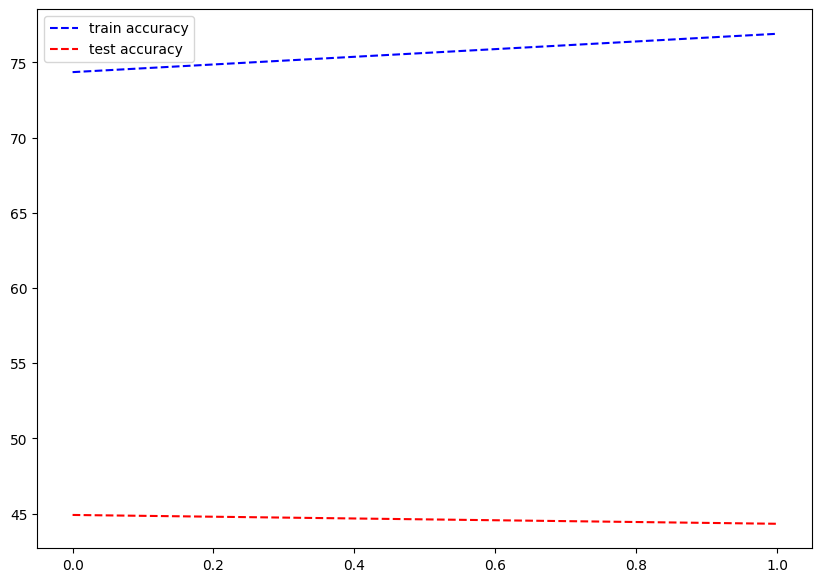

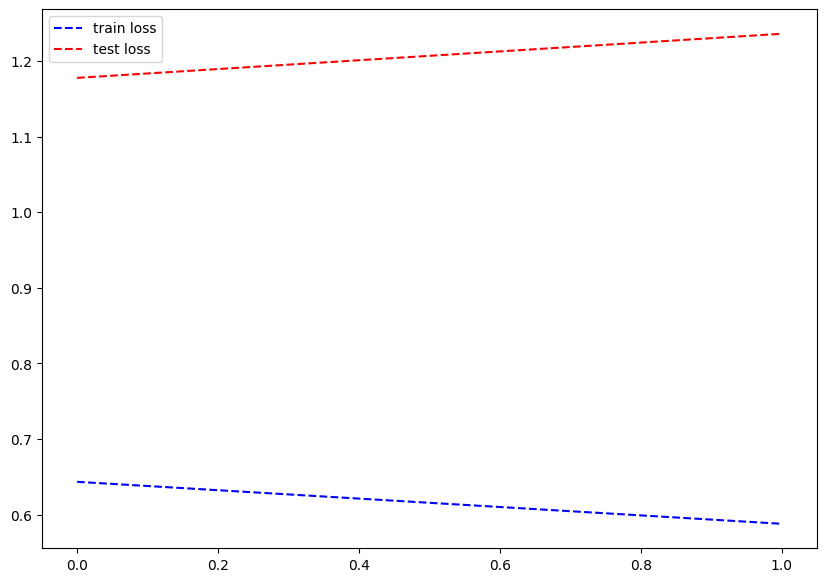

<Figure size 1000x1000 with 0 Axes>

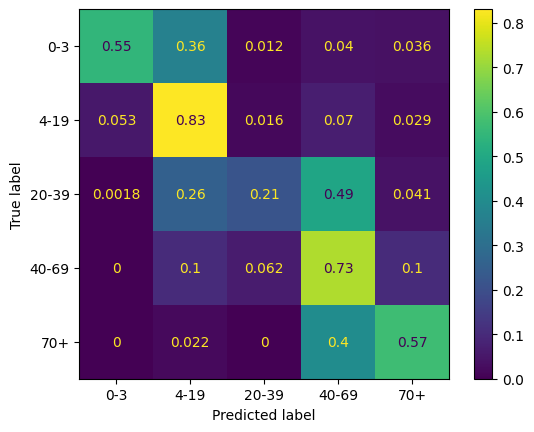

TRAINING COMPLETE


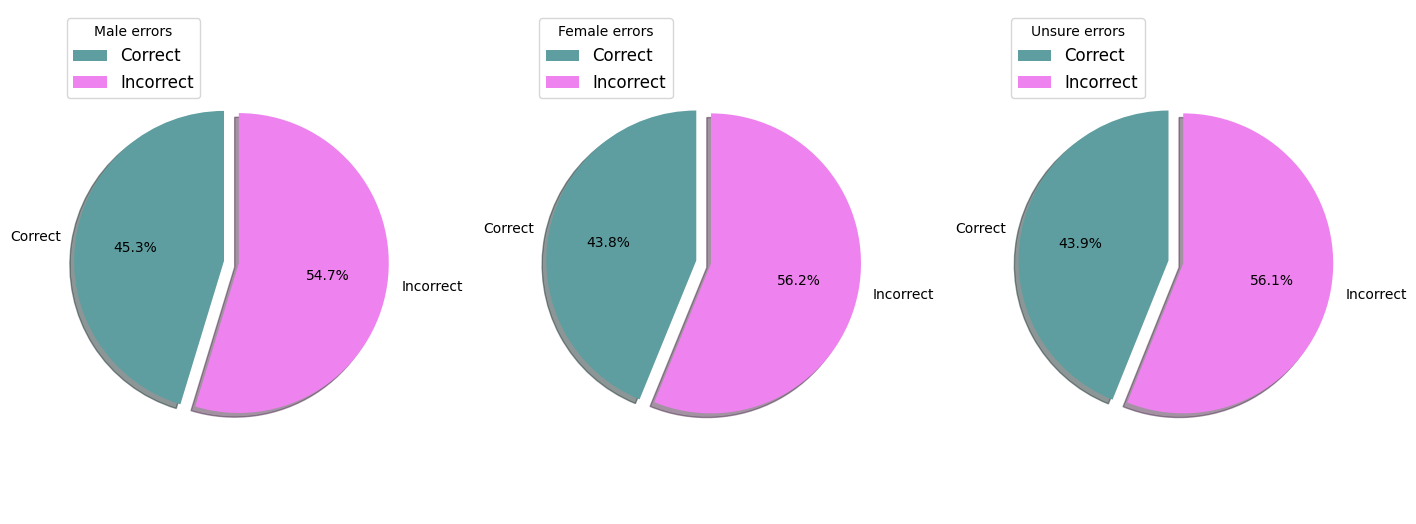

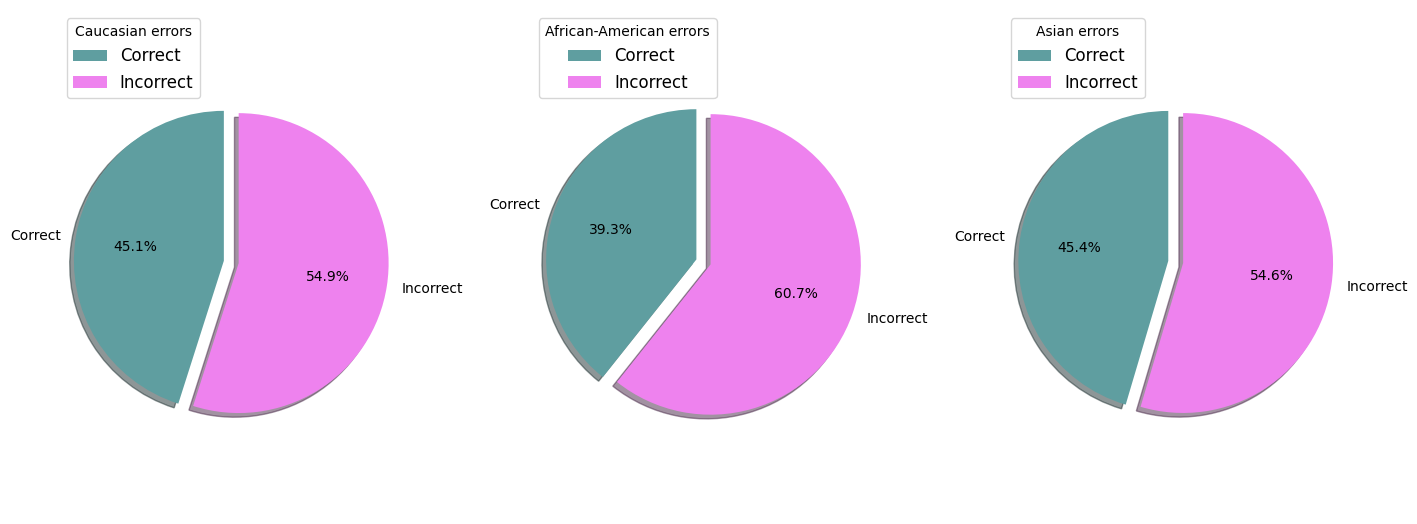

In [85]:
# Final step - loop over epochs
# loop over all the epochs
# store the information to draw graphics
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
flag=False
for epoch in range(epochs):
    print(f'Epoch {epoch+1} of {epochs}')
    if epoch ==epochs-1:
        flag=True
    #     calculating the loss and accuracy of test and train datasets
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                              optimizer, criterion)
    test_epoch_loss, test_epoch_acc,Confusion_matrix,Prediction_list = testing_model(model, test_loader,
                                                  criterion,flag)
#     adding to lists

    train_loss.append(train_epoch_loss)
    valid_loss.append(test_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(test_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: { test_epoch_loss:.3f}, validation acc: {test_epoch_acc:.3f}")
    print('-'*50)
#           saving current condition of a model
#     save_model(epochs, model, optimizer, criterion)

save_model(epochs, model, optimizer, criterion)
    # save the loss and accuracy plots
draw_plots(train_acc,valid_acc,train_loss,valid_loss)
# number of out features
num=5
final_matrix(Confusion_matrix,num)
wrongs=Infographics(Prediction_list)
print('TRAINING COMPLETE')

The best result of this model:


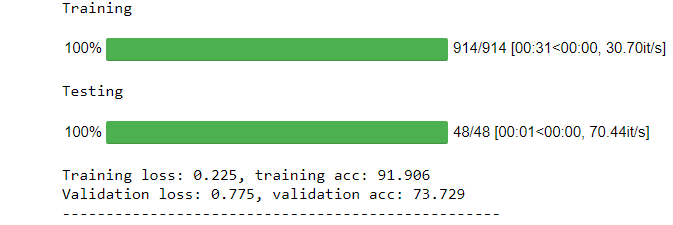

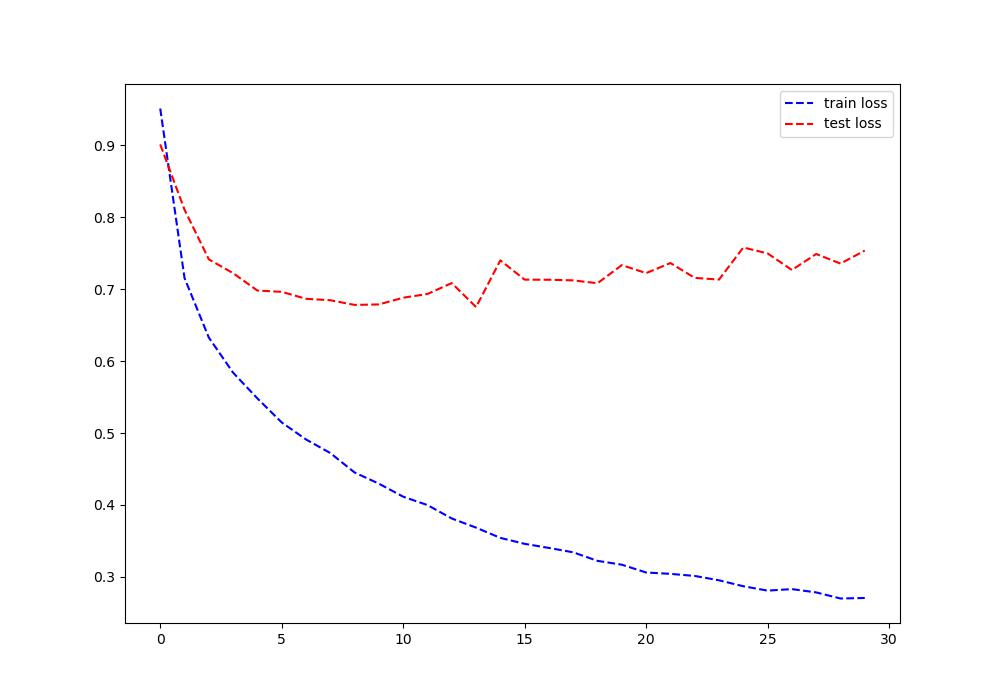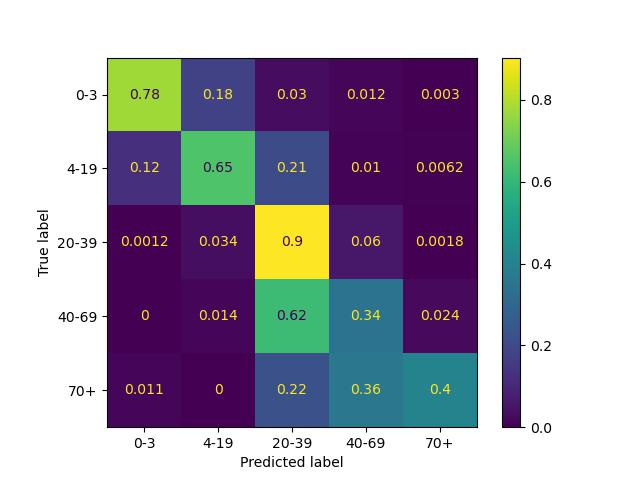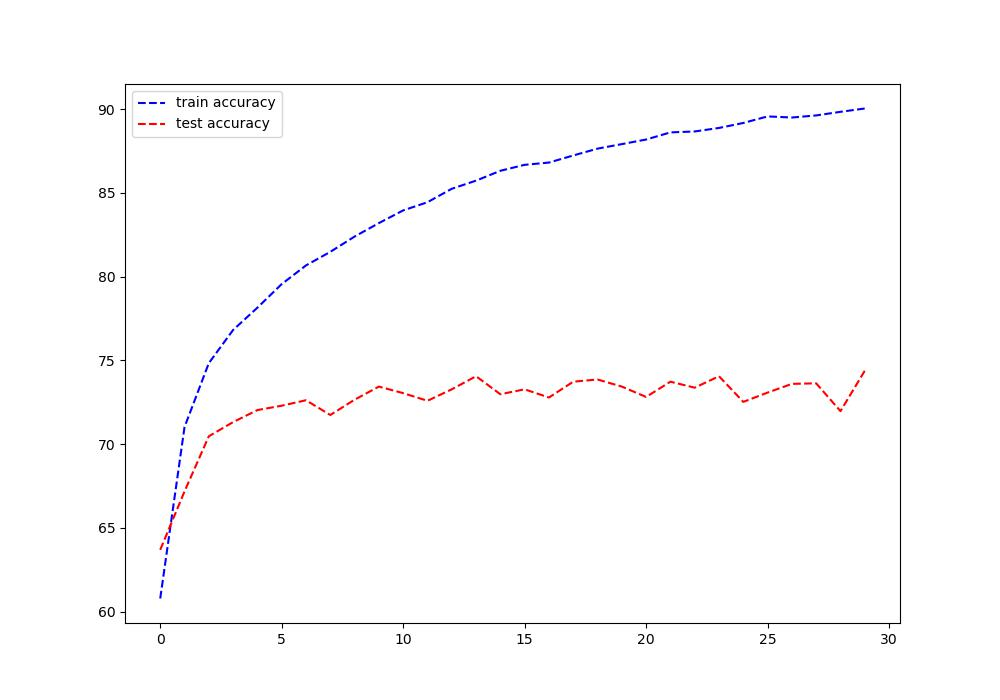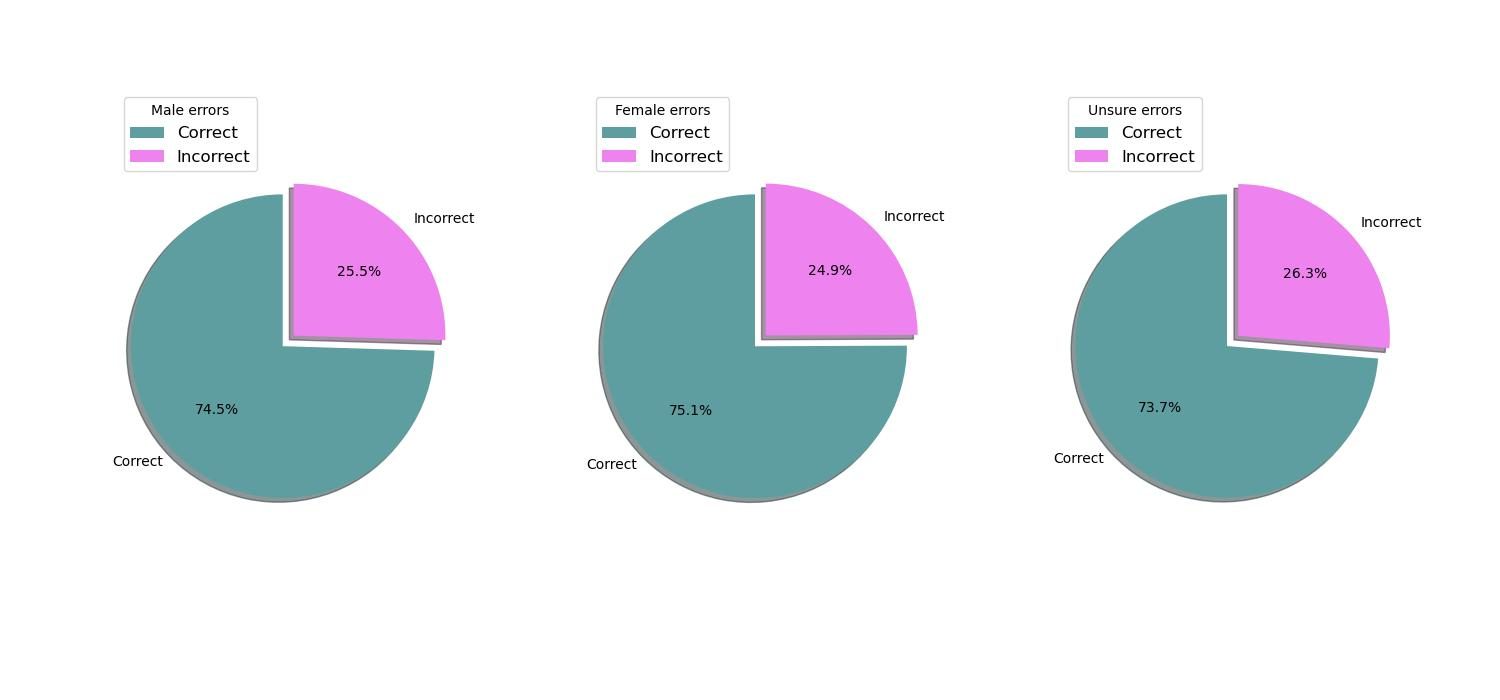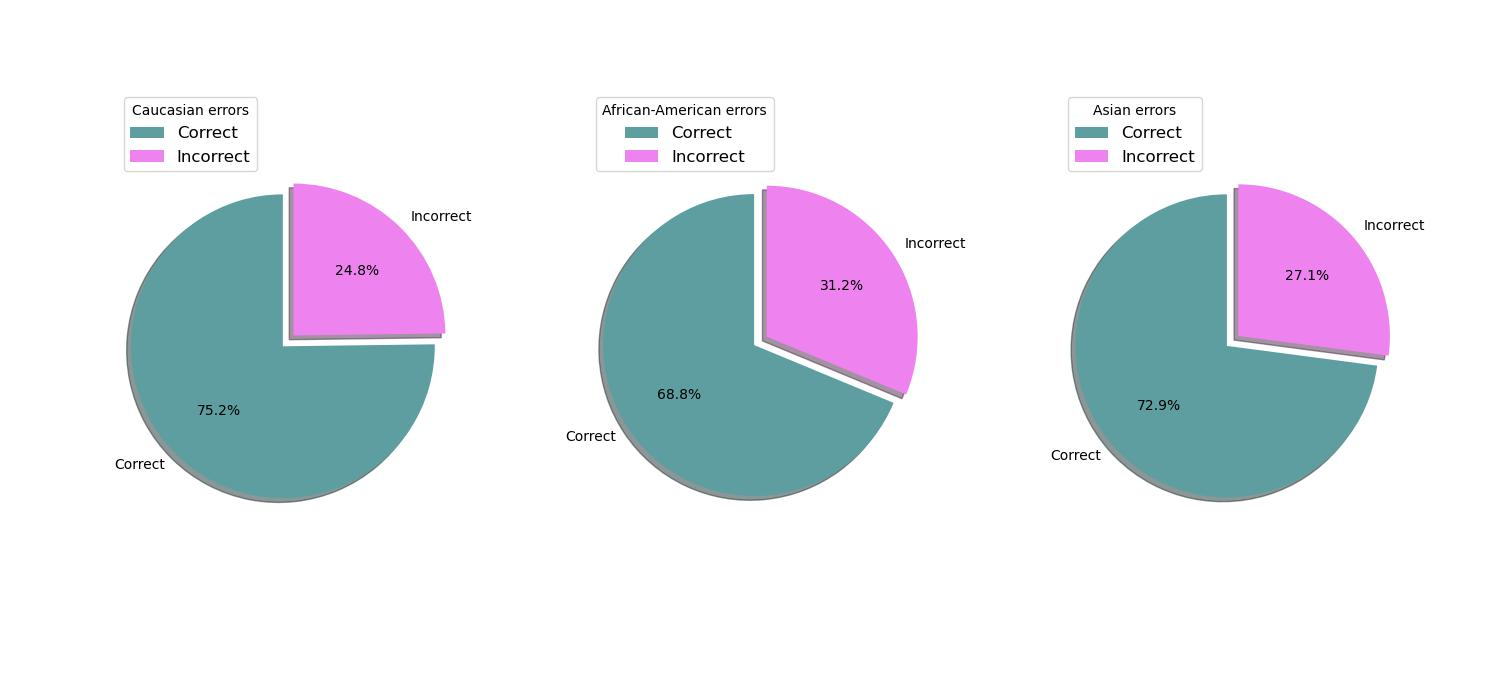